In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

In [2]:

spdatapath='./inputQuery/'
ad_spatial_ori=sc.read(spdatapath+'gene_by_cell.csv').transpose()
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()

#because it is 2d tissue slide so only upload the X and Y coordiante
ad_spatial_ori.obsm['spatial']=coordinate[:,[1,2]].astype(float)
adata=ad_spatial_ori
sample=[]
for i in range(len(ad_spatial_ori.obs_names)):
    sample.append('intestine')


df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_ct_name.csv')
sc_ctype_name=df.to_numpy()
df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_cluster.csv')
nico_cluster=df.to_numpy()
cellname=nico_cluster[:,0]
print("equal",np.array_equal(cellname,adata.obs_names))
d={}
for i in range(len(sc_ctype_name)):
    d[i]=sc_ctype_name[i][1]
ctname=[]
for i in range(len(cellname)):
        ctname.append( d[ nico_cluster[i,1]])
adata.obs['nico_ct']=ctname
adata.obs['sample']=np.array(sample)
adata.obs['sample']=pd.Categorical(adata.obs['sample'])

print('1',adata)

index=[]
for i in range(len(ctname)):
    flag=1
    if adata.obs['nico_ct'][i]=='NM':
        flag=0
    if adata.obs['nico_ct'][i]=='Cycling/GC B cell':
        flag=0
    if adata.obs['nico_ct'][i]=='pDC':
        flag=0
    if flag==1:
        index.append(i)

adata=adata[index]
print('2',adata)


equal True
1 AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'nico_ct', 'sample'
    obsm: 'spatial'
2 View of AnnData object with n_obs × n_vars = 7367 × 241
    obs: 'nico_ct', 'sample'
    obsm: 'spatial'


In [3]:
adata

View of AnnData object with n_obs × n_vars = 7367 × 241
    obs: 'nico_ct', 'sample'
    obsm: 'spatial'

In [4]:
#adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [5]:
adata_dis500 = adata.copy()

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.4)


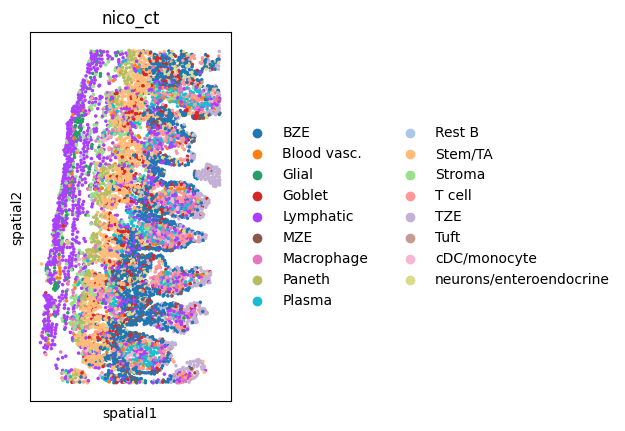

In [7]:
sc.pl.spatial(adata, color='nico_ct',spot_size=100)

In [8]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse',  database='CellChat') #signaling_type='Secreted Signaling',
print(df_cellchat.shape)
# We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0)
print(df_cellchat_filtered.shape)

(1209, 4)
(0, 0)


In [9]:
df1=pd.read_csv('NiCoLRdb.txt',header=None,sep='\t')
df2=df1.to_numpy().astype(str)
df=np.char.capitalize(df2)
print(df)

[['A2m' 'Lrp1' '# natmi_primary# natmi_additional']
 ['Aanat' 'Mtnr1a' '# natmi_primary# natmi_additional']
 ['Aanat' 'Mtnr1b' '# natmi_primary# natmi_additional']
 ...
 ['Zp3' 'Egfr' '# natmi_primary# natmi_additional# omnipath']
 ['Zp3' 'Mertk' '# natmi_additional# omnipath']
 ['Zp3' 'Mert' '# natmi_primary']]


In [10]:
df_cellchat = pd.DataFrame(data=df)

In [11]:
df_cellchat.shape

(4372, 3)

In [12]:
#ct.pp.ligand_receptor_database()

In [13]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0)
print(df_cellchat_filtered.shape)

(9, 3)


In [14]:
# We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)


(5, 3)


In [15]:
df_cellchat_filtered

,0,1,2
0,Apob,Sdc1,# natmi_additional
1,Cadm1,Cadm1,# natmi_primary# natmi_additional
2,Cd14,Itgam,# natmi_additional
3,Vcan,Cd44,# natmi_primary# natmi_additional# omnipath
4,Vim,Cd44,# natmi_primary# natmi_additional


In [16]:
ct.tl.spatial_communication(adata_dis500,
    database_name='nico_db', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [17]:
adata_dis500.write("output_commot_intestine.h5ad")